# Data import

In [1]:
import pandas as pd
import numpy as np

In [2]:
#loading sample dataset with 15 min. interval measurements of electricty
#from multiple buildings/compounds at Seattle university
df = pd.read_csv('seattlecom.csv')
df.head(5)

,Unnamed: 0,SuperMarketNew2004,SuperMarketPre1980,QuickServiceRestaurantNew2004,QuickServiceRestaurantPre1980,PrimarySchoolNew2004,PrimarySchoolPre1980,StripMallNew2004,StripMallPre1980,WarehouseNew2004,...,LargeOfficeNew2004,LargeOfficePre1980,HospitalNew2004,HospitalPre1980,MidriseApartmentNew2004,MidriseApartmentPre1980,SmallHotelNew2004,SmallHotelPre1980,LargeHotelNew2004,LargeHotelPre1980
0,0,41.879832,55.213981,6.772647,7.950168,28.495709,35.721850,7.32879,10.129500,9.057344,...,131.197418,146.576298,216.756700,277.295090,8.256180,10.787267,18.597551,26.874428,67.942908,84.070224
1,1,42.241800,47.781124,6.785294,7.956891,27.715278,32.640929,7.32879,9.433861,7.707912,...,118.964342,130.360934,217.217109,277.977491,8.270957,10.771443,18.571546,26.912565,67.136206,82.352637
2,2,42.528999,62.463834,4.791387,5.252067,27.715007,36.121347,7.32879,9.945126,8.856672,...,131.138323,147.847945,231.431638,294.773550,7.986947,10.455012,18.573122,26.798646,67.068804,82.207014
3,3,42.771294,50.343518,4.818858,5.244084,27.715750,32.643737,7.32879,9.433861,7.707912,...,118.964342,130.360934,231.925767,295.272465,7.989828,10.426749,18.556072,26.718426,66.845913,81.616933
4,4,42.997641,68.872855,4.819859,5.244791,27.716348,36.115752,7.32879,9.887803,8.793664,...,131.132365,147.822786,229.779860,295.685977,7.843991,10.259224,16.168120,23.414100,57.917515,68.263723


In [3]:
#for the sake of the exerices we will only consider the first building
df = df.iloc[:,1:2]
#adding timeseries component
dates = pd.date_range('1/1/2014', periods=297840, freq='15Min')
df= df.set_index(dates)
df.head(5)

,SuperMarketNew2004
2014-01-01 00:00:00,41.879832
2014-01-01 00:15:00,42.241800
2014-01-01 00:30:00,42.528999
2014-01-01 00:45:00,42.771294
2014-01-01 01:00:00,42.997641


In [4]:
#reduce the dataframe to facilitate training on local machine
df = df['2014-01-01':'2014-06-01']
df.head()

,SuperMarketNew2004
2014-01-01 00:00:00,41.879832
2014-01-01 00:15:00,42.241800
2014-01-01 00:30:00,42.528999
2014-01-01 00:45:00,42.771294
2014-01-01 01:00:00,42.997641


In [5]:
#standard code to create training and validation/test sets
from sklearn.model_selection import train_test_split
train_data_raw, validate_data_raw = train_test_split(df, test_size=0.2)

In [6]:
train_data_raw.head()

,SuperMarketNew2004
2014-03-21 19:45:00,130.300003
2014-02-09 03:00:00,67.162543
2014-03-22 03:15:00,70.620482
2014-01-03 12:00:00,50.538510
2014-05-04 03:15:00,77.938712


In [7]:
#### here starts the action #####

In [8]:
# Choose only columns containing features we want to use for training
feature_list = ["SuperMarketNew2004"]
features = len(feature_list)
train_data_selected = train_data_raw[feature_list].as_matrix().astype(np.float32)
validate_data_selected = validate_data_raw[feature_list].as_matrix().astype(np.float32)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


# Data visualization

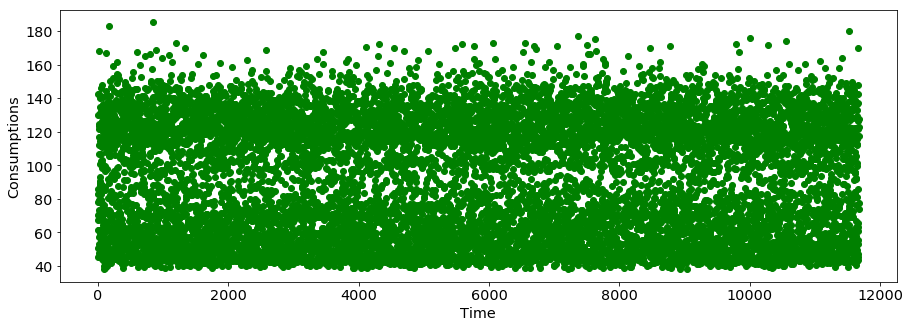

In [9]:
%matplotlib inline

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(30,10)
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sample = train_data_raw

plt.plot(range(len(train_data_raw)), train_data_raw[feature_list], "go")
plt.ylabel('Consumptions')
plt.xlabel('Time')
plt.show()

# Multi layer perceptron

## Data preparation

In [15]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

In [20]:
ctx = mx.cpu() # use mx.cpu() on machines with no GPU or a weak 960M 

In [21]:
# Convert a dataset into a windowed format - append *window - 1* records to the back of each record. 

def prepare_dataset(dataset, window):
    windowed_data = []
    for i in range(len(dataset)):
        start = i + 1 - window if i + 1 - window >= 0 else 0
        observation = dataset[start : i + 1,]
        to_pad = (window - i - 1 if i + 1 - window < 0 else 0) * features
        observation = observation.flatten()
        observation = np.lib.pad(observation, (to_pad, 0), 'constant', constant_values=(0, 0))
        windowed_data.append(observation)
    return np.array(windowed_data)
    
# the window size, determines the duration of memory 
# the bigger the values is, the longer our network will "retain" past information i.e. it will take longer
# for newer state to become significant but it will also mean we will use the time dependency factor more into account.
window = 50

# Convert our data into windowed formats
data_train = prepare_dataset(train_data_selected, window)
data_validate = prepare_dataset(validate_data_selected, window)
rows = len(data_train)
split_factor = 0.8
train = data_train[0:int(rows*split_factor)]
test = data_train[int(rows*split_factor):]

In [22]:
# Create an iterator, which will feed our data in a batched fashion into MXNet
batch_size = 256
train_data = mx.gluon.data.DataLoader(train, batch_size, last_batch='keep', shuffle=False)
test_data = mx.gluon.data.DataLoader(test, batch_size, last_batch='keep', shuffle=False)

In [23]:
### Network modeeling ###
# For this network we will use our windowed data representation, so each record will actually contain all the features
# from *window* number of records hence or total input size:
total_features = window * features

model = gluon.nn.Sequential()
with model.name_scope():
    # Connection between input and first hidden layer
    model.add(gluon.nn.Dense(16, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))

    model.add(gluon.nn.Dense(8, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))
    
    model.add(gluon.nn.Dense(16, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))
    
    # Connection between hidden layer and our output layer - since it is an autoencoder we want the size to be same as input size
    model.add(gluon.nn.Dense(total_features))

# Use the non default Xavier parameter initializer
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

# Use Adam optimizer for training
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

# Similarly to previous example we will use L2 loss for evaluation
L = gluon.loss.L2Loss()

In [24]:
### training ###

# Evaluation function
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = data
        output = model(data)
        loss = L(output, label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return loss_avg



In [25]:
%%time
epochs = 50

all_train_mse = []
all_test_mse = []

# Gluon training loop
for e in range(epochs):
    for i, data in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = data
        with autograd.record():
            output = model(data)
            loss = L(output, label)
            loss.backward()
        trainer.step(data.shape[0])
    
    train_mse = evaluate_accuracy(train_data, model, L)
    test_mse = evaluate_accuracy(test_data, model, L)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)

Wall time: 14.8 s


In [27]:
# Plot the training vs test mse
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    figsize(16, 7)
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

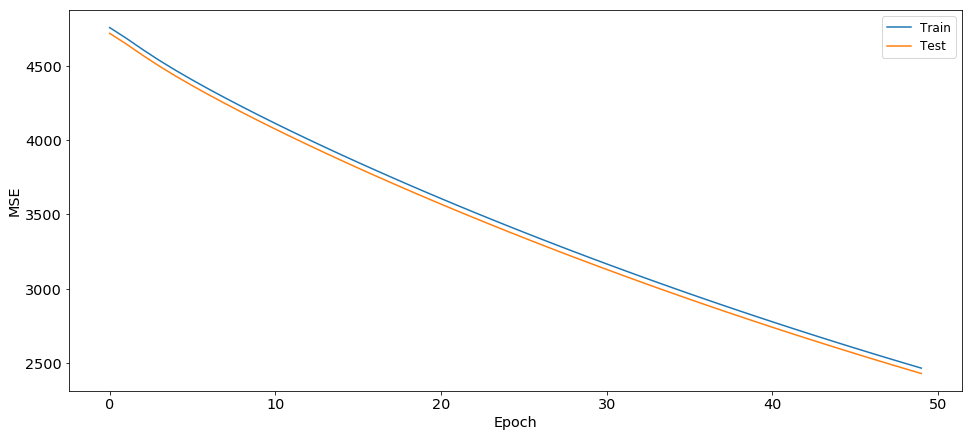

In [28]:
plot_errors(all_train_mse, all_test_mse)

# Long-short term memory

## Data preparation

In [29]:
# Setup iterators for Gluon to feed our model with batched data during training
batch_size = 258

# Split the data into train and test
rows = len(train_data_selected)
split_factor = 0.8
train = train_data_selected.astype(np.float32)[0:int(rows*split_factor)]
test = train_data_selected.astype(np.float32)[int(rows*split_factor):]

train_data = mx.gluon.data.DataLoader(train, batch_size, shuffle=False)
test_data = mx.gluon.data.DataLoader(test, batch_size, shuffle=False)

## Network modelling

In [40]:
window = 1

model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(window, dropout=0.35))
    model.add(mx.gluon.rnn.LSTM(features))

# Use the non default Xavier parameter initializer
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

# Use Adam optimizer for training
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.1})

# Similarly to previous example we will use L2 loss for evaluation
L = gluon.loss.L2Loss()

## Training

In [41]:
# Evaluation function
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, window, features))
        label = data
        output = model(data)
        loss = L(output, label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return loss_avg

In [58]:
%%time
epochs = 5

all_train_mse = []
all_test_mse = []

window = 2

# Gluon training loop
for e in range(epochs):
    for i, data in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1, window, features))
        label = data
        with autograd.record():
            output = model(data)
            loss = L(output, label)
        loss.backward()
        trainer.step(batch_size)
    
    train_mse = evaluate_accuracy(train_data, model, L)
    test_mse = evaluate_accuracy(test_data, model, L)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)

Wall time: 2min 57s


In [59]:
# Plot the training vs test mse
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    figsize(16, 7)
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

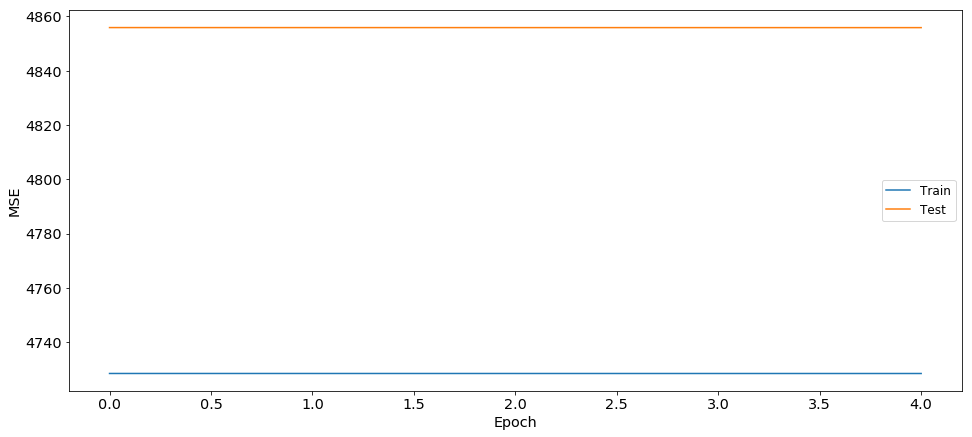

In [60]:
plot_errors(all_train_mse, all_test_mse)

In [61]:
# Helper method running predictions in a batched fashion
def predict(to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(ctx).reshape((-1,features,1))
        out = model(input)
        prediction = L(out, input).asnumpy().flatten()
        predictions = np.append(predictions, prediction)
    return predictions

In [62]:
train_data = mx.gluon.data.DataLoader(train_data_selected.astype(np.float32), batch_size, shuffle=False)

train_predictions = predict(train_data, L)
threshold =  np.mean(train_predictions) + 3*np.std(train_predictions)

## Validation

In [63]:
validate_data = mx.gluon.data.DataLoader(validate_data_selected.astype(np.float32), batch_size, shuffle=False)

validation_predictions = predict(validate_data, L)

In [64]:
anomaly = list(map(lambda v: v > threshold, validation_predictions))

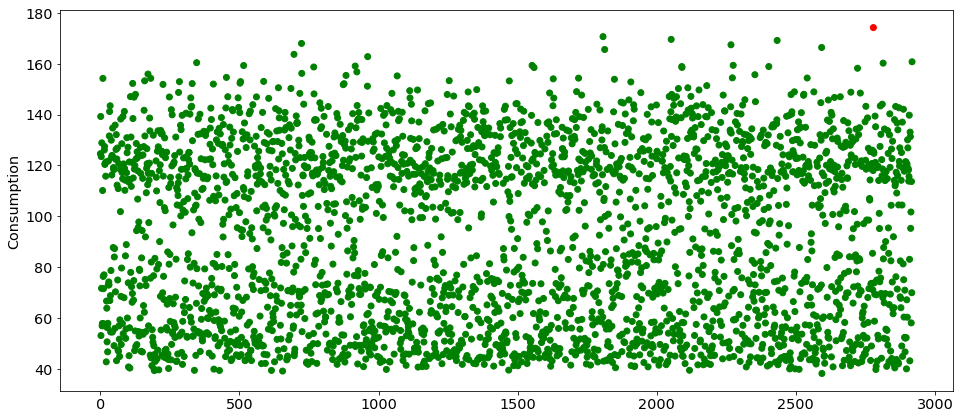

In [65]:
anomaly = list(map(lambda v: "red" if v else "green", anomaly))
figsize(16, 7)
plt.scatter(list(range(len(validate_data_raw["SuperMarketNew2004"]))), validate_data_raw["SuperMarketNew2004"], c=anomaly)
plt.ylabel('Consumption')
plt.show()